In [59]:
import wandb
import warnings
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from dice_ml.explainer_interfaces.explainer_base import UserConfigValidationException
from datetime import timedelta
import os
import re
import joblib
import sys
from aeon.utils.numba.stats import row_mean
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

from collections import Counter
from scripts.SEP_CFE_functions import *
from slim_tsf.func.BaseSLIM import *
from slim_tsf.func._slim_TSF import *
from slim_tsf.func._sliding_intervals import *
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from slim_tsf.func._slim_TSF import SlimTimeSeriesForestClassifier

In [3]:
#load data from file
data = np.load("/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/processed/sep_slim_tsf_input_dataset.npz")
X = data['X']
y = data['y']

In [4]:
temp_x, test_x, temp_y, test_y = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
train_x, val_x, train_y, val_y = train_test_split(temp_x, temp_y, test_size=0.3, stratify=temp_y, random_state=42)

print(f"Train size: {train_x.shape[0]}, Val size: {val_x.shape[0]}, Test size: {test_x.shape[0]}")

Train size: 1416, Val size: 608, Test size: 868


Class distribution in the dataset:
Class 0: 2648 samples with ratio 91.56%
Class 1: 244 samples with ratio 8.44%


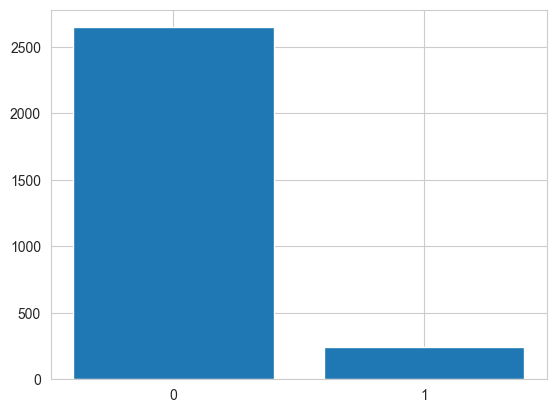

In [5]:
classes = np.unique(y)
counts = np.array([np.sum(y == c) for c in classes])
print("Class distribution in the dataset:")
for c, count in zip(classes, counts):
    print(f"Class {c}: {count} samples with ratio {count/len(y):.2%}")
plt.bar(classes, counts)
plt.xticks(classes, [str(c) for c in classes])
plt.show()


In [6]:
# --- Define the parameter grids ---
window_sizes = [360, 240, 180, 120, 90, 60, 45, 30, 15, 6]
step_ratios = [0.2, 0.5]
class_weights = [
    "balanced",
    {0:1, 1:1},
    {0:1, 1:2},
    {0:1, 1:5},
    {0:1, 1:11.5},
]

# --- Build one model per (window, step_ratio, class_weight) ---
models = {}
model_id = 0

for win in window_sizes:
    for step in step_ratios:
        for cw in class_weights:
            name = f"win{win}_step{step}_cw{cw if isinstance(cw,str) else list(cw.values())}"
            clf = SlimTimeSeriesForestClassifier(
                sec_trans=False,
                bootstrap=False,
                n_estimators=300,
                max_dep=5,
                random_state=42,
                windows=[win],
                windows_steps_ratio=step,
                class_weights=cw,
                features=[row_mean]
            )
            models[name] = clf
            model_id += 1

print(f"Configured {len(models)} models total.")


Configured 100 models total.


In [7]:
topk_results = {}

for name, clf in models.items():
    print(f"Training {name} ...")
    clf.fit(train_x, train_y)

    Xt = clf.tnf._fit_transform(train_x, train_y)
    importances = clf.clf.feature_importances_
    intervals = clf.tnf.intervals_

    # Rank & keep top 20
    ranked = sorted(zip(importances, intervals), key=lambda x: x[0], reverse=True)
    topk_results[name] = ranked[:20]


print("Extracted top-20 intervals for all models.")

Training win360_step0.2_cwbalanced ...
Training win360_step0.2_cw[1, 1] ...
Training win360_step0.2_cw[1, 2] ...
Training win360_step0.2_cw[1, 5] ...
Training win360_step0.2_cw[1, 11.5] ...
Training win360_step0.5_cwbalanced ...
Training win360_step0.5_cw[1, 1] ...
Training win360_step0.5_cw[1, 2] ...
Training win360_step0.5_cw[1, 5] ...
Training win360_step0.5_cw[1, 11.5] ...
Training win240_step0.2_cwbalanced ...
Training win240_step0.2_cw[1, 1] ...
Training win240_step0.2_cw[1, 2] ...
Training win240_step0.2_cw[1, 5] ...
Training win240_step0.2_cw[1, 11.5] ...
Training win240_step0.5_cwbalanced ...
Training win240_step0.5_cw[1, 1] ...
Training win240_step0.5_cw[1, 2] ...
Training win240_step0.5_cw[1, 5] ...
Training win240_step0.5_cw[1, 11.5] ...
Training win180_step0.2_cwbalanced ...
Training win180_step0.2_cw[1, 1] ...
Training win180_step0.2_cw[1, 2] ...
Training win180_step0.2_cw[1, 5] ...
Training win180_step0.2_cw[1, 11.5] ...
Training win180_step0.5_cwbalanced ...
Training wi

In [66]:
import pandas as pd

# channel order — must match dataset
channel_labels = ["p3_flux_ic", "p5_flux_ic", "p7_flux_ic", "long"]

all_features = []

for name, clf in models.items():
    print(f"Extracting row_mean intervals from {name} ...")

    Xt = clf.tnf._fit_transform(train_x, train_y)
    importances = clf.clf.feature_importances_
    intervals = clf.tnf.intervals_

    # keep only row_mean
    for imp, (start, end, ch, func, *_) in zip(importances, intervals):
        if callable(func) and getattr(func, "__name__", "") != "row_mean":
            continue
        all_features.append({
            "model": name,
            "channel": channel_labels[ch] if ch < len(channel_labels) else f"Ch{ch}",
            "start": start,
            "end": end,
            "feature": getattr(func, "__name__", str(func)),
            "importance": imp
        })




Extracting row_mean intervals from win360_step0.2_cwbalanced ...
Extracting row_mean intervals from win360_step0.2_cw[1, 1] ...
Extracting row_mean intervals from win360_step0.2_cw[1, 2] ...
Extracting row_mean intervals from win360_step0.2_cw[1, 5] ...
Extracting row_mean intervals from win360_step0.2_cw[1, 11.5] ...
Extracting row_mean intervals from win360_step0.5_cwbalanced ...
Extracting row_mean intervals from win360_step0.5_cw[1, 1] ...
Extracting row_mean intervals from win360_step0.5_cw[1, 2] ...
Extracting row_mean intervals from win360_step0.5_cw[1, 5] ...
Extracting row_mean intervals from win360_step0.5_cw[1, 11.5] ...
Extracting row_mean intervals from win240_step0.2_cwbalanced ...
Extracting row_mean intervals from win240_step0.2_cw[1, 1] ...
Extracting row_mean intervals from win240_step0.2_cw[1, 2] ...
Extracting row_mean intervals from win240_step0.2_cw[1, 5] ...
Extracting row_mean intervals from win240_step0.2_cw[1, 11.5] ...
Extracting row_mean intervals from win24

In [67]:
# --- Build dataframe
df_rowmean = pd.DataFrame(all_features)

# --- Sort within each channel & select top-20
df_top20_rowmean = (
    df_rowmean.sort_values(["channel", "importance"], ascending=[True, False])
              .groupby("channel")
              .head(20)
              .reset_index(drop=True)
)

# --- Map indices to time in minutes
start_min, end_min = 300, 660
n_time = train_x.shape[2]
df_top20_rowmean["start_min"] = df_top20_rowmean["start"] / n_time * (end_min - start_min) + start_min
df_top20_rowmean["end_min"]   = df_top20_rowmean["end"]   / n_time * (end_min - start_min) + start_min

print("\n🌟 Top-20 row_mean Intervals per Channel (Aggregated Across Models) 🌟")
print(df_top20_rowmean[["channel", "start_min", "end_min", "importance"]])


🌟 Top-20 row_mean Intervals per Channel (Aggregated Across Models) 🌟
       channel  start_min  end_min  importance
0         long      300.0    660.0    0.035124
1         long      300.0    660.0    0.035124
2         long      300.0    660.0    0.032901
3         long      300.0    660.0    0.032901
4         long      396.0    636.0    0.032228
..         ...        ...      ...         ...
75  p7_flux_ic      540.0    660.0    0.019673
76  p7_flux_ic      480.0    660.0    0.019195
77  p7_flux_ic      540.0    660.0    0.017982
78  p7_flux_ic      300.0    540.0    0.015303
79  p7_flux_ic      540.0    660.0    0.014979

[80 rows x 4 columns]


In [68]:
df_top20_rowmean

,model,channel,start,end,feature,importance,start_min,end_min
0,"win360_step0.2_cw[1, 1]",long,0,360,row_mean,0.035124,300.0,660.0
1,"win360_step0.5_cw[1, 1]",long,0,360,row_mean,0.035124,300.0,660.0
2,"win360_step0.2_cw[1, 2]",long,0,360,row_mean,0.032901,300.0,660.0
3,"win360_step0.5_cw[1, 2]",long,0,360,row_mean,0.032901,300.0,660.0
4,"win240_step0.2_cw[1, 11.5]",long,96,336,row_mean,0.032228,396.0,636.0
...,...,...,...,...,...,...,...,...
75,"win120_step0.5_cw[1, 2]",p7_flux_ic,240,360,row_mean,0.019673,540.0,660.0
76,"win180_step0.5_cw[1, 1]",p7_flux_ic,180,360,row_mean,0.019195,480.0,660.0
77,"win120_step0.5_cw[1, 1]",p7_flux_ic,240,360,row_mean,0.017982,540.0,660.0
78,"win240_step0.5_cw[1, 1]",p7_flux_ic,0,240,row_mean,0.015303,300.0,540.0


In [50]:
def compute_interval_frequency(topk_results, n_time, n_channels=4, func_filter="row_mean"):
    freq_mat_1 = np.zeros((n_channels, n_time))
    interval_counter = {}

    for model_name, ranked in topk_results.items():
        for imp, (start, end, ch, func, *_) in ranked:
            if getattr(func, "__name__", "") != func_filter:
                continue
            freq_mat_1[ch, start:end] += 1
            interval_counter[(start, end, ch)] = interval_counter.get((start, end, ch), 0) + 1

    freq_mat = freq_mat_1 / (freq_mat_1.max(axis=1, keepdims=True) + 1e-9)
    return freq_mat, interval_counter, freq_mat_1

In [51]:
channel_labels = ["p3_flux_ic", "p5_flux_ic", "p7_flux_ic", "long"]

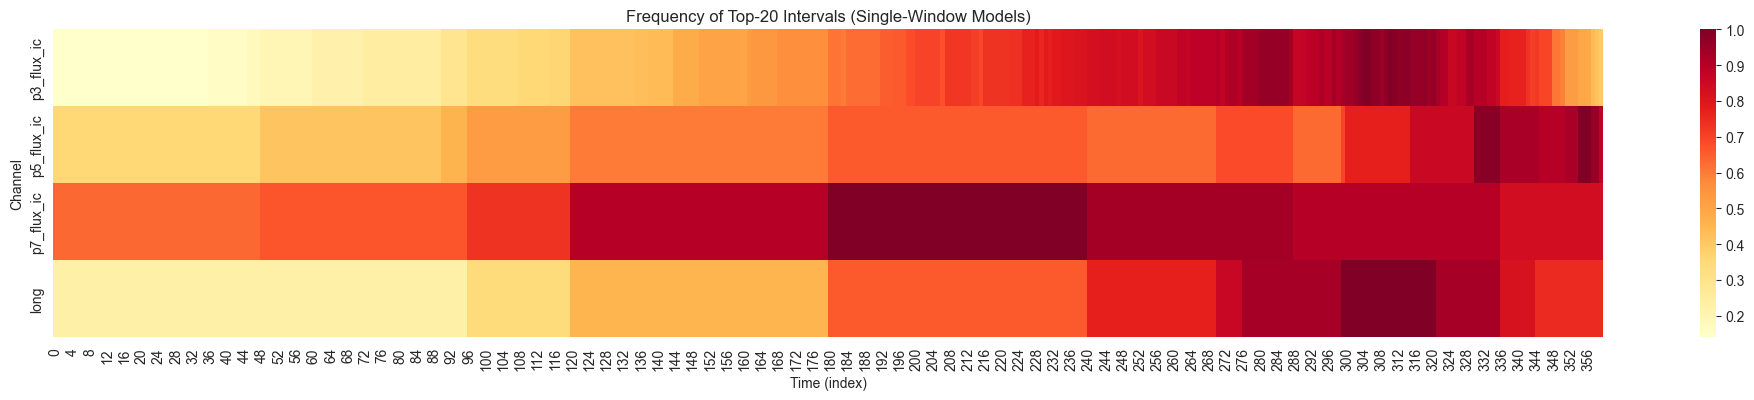

In [52]:
freq_mat, interval_counter, freq_mat_1= compute_interval_frequency(topk_results, train_x.shape[2])

plt.figure(figsize=(25,4))
sns.heatmap(freq_mat, cmap="YlOrRd", yticklabels=channel_labels)
plt.title("Frequency of Top-20 Intervals (Single-Window Models)")
plt.xlabel("Time (index)")
plt.ylabel("Channel")
plt.show()


In [58]:
print(freq_mat_1.shape)
for i in range(len(topk_results)):
    ch_idx = i % freq_mat_1.shape[0]
    time_idx = np.unravel_index(np.argmax(freq_mat_1[ch_idx]), freq_mat_1[ch_idx].shape)[0]
    print(f"Channel: {channel_labels[ch_idx]}, Time Index with Max Frequency: {time_idx}, Frequency: {freq_mat_1[ch_idx, time_idx]}")


(4, 360)
100


In [41]:
sorted_intervals = sorted(interval_counter.items(), key=lambda x: x[1], reverse=True)
print("total unique intervals found:", len(sorted_intervals))

for (start, end, ch), count in sorted_intervals:
    print(f"{channel_labels[ch]} | [{start}:{end}] | occurred {count} times")

total unique intervals found: 192
p3_flux_ic | [0:360] | occurred 10 times
p5_flux_ic | [0:360] | occurred 10 times
long | [0:360] | occurred 10 times
p7_flux_ic | [0:360] | occurred 10 times
p3_flux_ic | [0:240] | occurred 10 times
p5_flux_ic | [0:240] | occurred 10 times
p3_flux_ic | [180:360] | occurred 10 times
p3_flux_ic | [240:360] | occurred 10 times
p3_flux_ic | [270:360] | occurred 10 times
p3_flux_ic | [180:270] | occurred 10 times
p3_flux_ic | [300:360] | occurred 10 times
p3_flux_ic | [240:300] | occurred 10 times
p3_flux_ic | [330:360] | occurred 10 times
p3_flux_ic | [300:330] | occurred 10 times
p3_flux_ic | [270:300] | occurred 10 times
p3_flux_ic | [336:351] | occurred 10 times
p3_flux_ic | [342:348] | occurred 10 times
p3_flux_ic | [354:360] | occurred 10 times
p3_flux_ic | [330:336] | occurred 10 times
p3_flux_ic | [324:330] | occurred 10 times
long | [180:360] | occurred 9 times
p5_flux_ic | [180:360] | occurred 9 times
p5_flux_ic | [330:360] | occurred 9 times
p5_f

In [12]:
def compute_channel_independent_importance(topk_results, n_time, start_min=300, end_min=660, func_filter="row_mean"):
    """
    Collapse channel dimension → global time importance.
    Accumulates importance over start:end across all models and channels.

    Returns both the time axis (in minutes) and normalized importance.
    """
    global_importance = np.zeros(n_time)

    for model_name, ranked in topk_results.items():
        for imp, (start, end, ch, func, *_) in ranked:
            if func_filter and getattr(func, "__name__", "") != func_filter:
                continue
            global_importance[start:end] += imp

    # Normalize
    global_importance /= global_importance.max() + 1e-9

    # Create actual time axis (linear mapping)
    time_axis = np.linspace(start_min, end_min, n_time, endpoint=False)
    return time_axis, global_importance

In [13]:
time_axis, global_importance = compute_channel_independent_importance(
    topk_results,
    n_time=train_x.shape[2],
    start_min=300,
    end_min=660
)

In [14]:
from scipy.signal import find_peaks

peaks, props = find_peaks(global_importance, height=0.5)
peak_heights = props["peak_heights"]
peak_times = time_axis[peaks]

print("Detected Important Time Intervals (≥ 50% normalized importance)")
print("=" * 70)
for t, h in zip(peak_times, peak_heights):
    window = 3  # ±3 minutes window
    print(f"[{t - window:.0f} – {t + window:.0f}] min | Peak = {h:.3f}")

Detected Important Time Intervals (≥ 50% normalized importance)
[451 – 457] min | Peak = 0.590
[478 – 484] min | Peak = 0.732
[499 – 505] min | Peak = 0.759
[508 – 514] min | Peak = 0.775
[525 – 531] min | Peak = 0.810
[527 – 533] min | Peak = 0.813
[543 – 549] min | Peak = 0.854
[546 – 552] min | Peak = 0.852
[558 – 564] min | Peak = 0.877
[567 – 573] min | Peak = 0.927
[570 – 576] min | Peak = 0.932
[577 – 583] min | Peak = 0.969
[582 – 588] min | Peak = 0.970
[591 – 597] min | Peak = 0.934
[594 – 600] min | Peak = 0.939
[599 – 605] min | Peak = 0.991
[601 – 607] min | Peak = 0.998
[607 – 613] min | Peak = 0.998
[611 – 617] min | Peak = 0.992
[615 – 621] min | Peak = 0.996
[617 – 623] min | Peak = 1.000
[629 – 635] min | Peak = 0.970
[631 – 637] min | Peak = 0.962
[637 – 643] min | Peak = 0.874
[643 – 649] min | Peak = 0.836
[649 – 655] min | Peak = 0.767


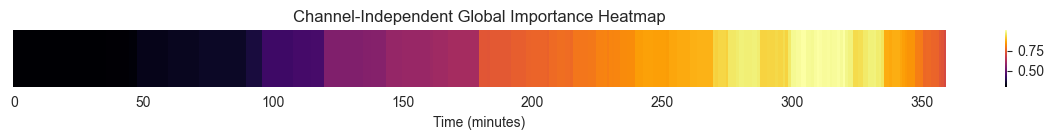

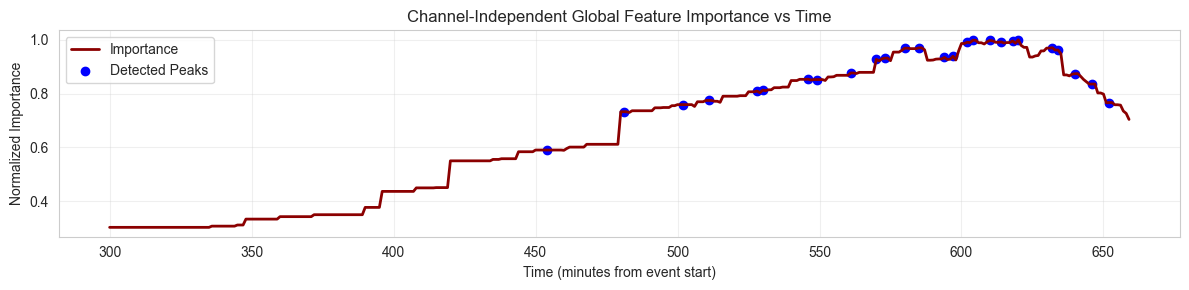

In [15]:
heat_data = global_importance[np.newaxis, :]

plt.figure(figsize=(12, 1.5))
sns.heatmap(
    heat_data,
    cmap="inferno",
    cbar=True,
    xticklabels=50,   # every 50 minutes
    yticklabels=False
)
plt.title("Channel-Independent Global Importance Heatmap")
plt.xlabel("Time (minutes)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(time_axis, global_importance, color="darkred", linewidth=2, label="Importance")
plt.scatter(peak_times, peak_heights, color="blue", label="Detected Peaks")
plt.title("Channel-Independent Global Feature Importance vs Time")
plt.xlabel("Time (minutes from event start)")
plt.ylabel("Normalized Importance")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
